<a href="https://colab.research.google.com/github/tannerskluz/SpotifyClassifier/blob/main/base_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load song dataset

In [89]:
url = 'https://raw.githubusercontent.com/tannerskluz/SpotifyClassifier/main/data.csv'
df = pd.read_csv(url)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [91]:
df.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [92]:
df.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [93]:
df['explicit'].value_counts() # very imbalanced

0    162507
1     11882
Name: explicit, dtype: int64

In [94]:
df.drop(columns=['id', 'name', 'artists', 'release_date'],inplace=True)
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.991000,0.598,168333,0.224,0,0.000522,5,0.3790,-12.628,0,12,0.0936,149.976,0.6340,1920
1,0.643000,0.852,150200,0.517,0,0.026400,5,0.0809,-7.261,0,7,0.0534,86.889,0.9500,1920
2,0.993000,0.647,163827,0.186,0,0.000018,0,0.5190,-12.098,1,4,0.1740,97.600,0.6890,1920
3,0.000173,0.730,422087,0.798,0,0.801000,2,0.1280,-7.311,1,17,0.0425,127.997,0.0422,1920
4,0.295000,0.704,165224,0.707,1,0.000246,10,0.4020,-6.036,0,2,0.0768,122.076,0.2990,1920


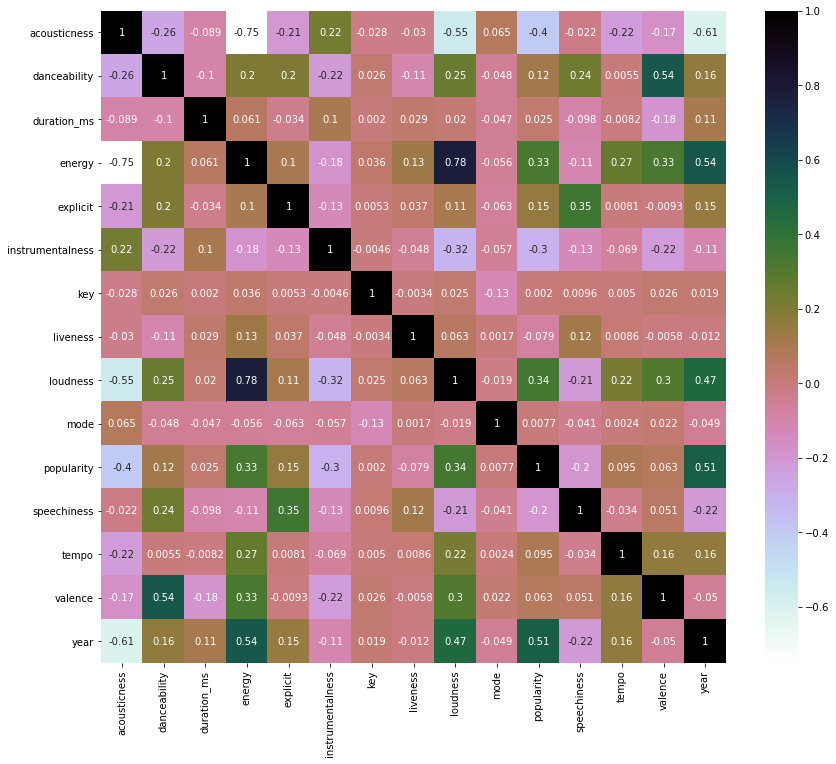

In [95]:
plt.figure(figsize=(14,12)) 
sns.heatmap(df.corr(), annot=True, cmap='cubehelix_r')
plt.show()

In [96]:
# do some more feature selection based on correlation heatmap
# remove ones with less than .15 absolute correlation
df = df.drop(columns=['duration_ms', 'key', 'liveness', 'mode', 'tempo', 'valence',
                      'loudness', 'instrumentalness']) 

In [111]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE # pip3 install imblearn delayed
import matplotlib.patches as patches

import pydotplus
from sklearn.tree import export_graphviz

# helper function for rendering tree
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [117]:
# split dataset into features and target variable
X = df.drop(columns='explicit')
y = df.explicit

# generate synthetic samples from minority class using kNN
sm = SMOTE(random_state=0, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3)

# instantiate tree 
clf_tree3 = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=0)
clf_tree4 = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=0)
clf_tree5 = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=0)

clf_tree4.fit(X_train, y_train)
y_pred = clf_tree4.predict(X_test)
print('TRAIN-TEST SPLIT:')
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {}'.format(precision_score(y_test, y_pred)))
print('Recall score: {}'.format(recall_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('====')

scoring = {'acc' : 'accuracy',  # dict of metrics 
           'prec': 'precision',
           'rec' : 'recall',
           'f1'  : 'f1'}

# 5-fold cv
scores = cross_validate(estimator=clf_tree4,X=X_res, y=y_res, cv=5, scoring=scoring,
                        return_train_score=True, return_estimator=True)

# print eval metrics for each fold
print("5-fold CV:")
print("Accuracy:", scores['test_acc'], ": mean:", sum(scores['test_acc'])/len(scores['test_acc']))
print("Precision:", scores['test_prec'], ": mean:", sum(scores['test_prec'])/len(scores['test_prec']))
print("Recall:", scores['test_rec'], ": mean:", sum(scores['test_rec'])/len(scores['test_rec']))
print("f-measure:", scores['test_f1'], ": mean:", sum(scores['test_f1'])/len(scores['test_f1']))

TRAIN-TEST SPLIT:
Accuracy score: 0.8681606071483514
Precision score: 0.8662793076639798
Recall score: 0.8701424138427077
F1 score: 0.8682065635284348
====
5-fold CV:
Accuracy: [0.856622   0.86597542 0.8714367  0.87105211 0.86163503] : mean: 0.8653442506808198
Precision: [0.84794813 0.85422437 0.86529093 0.86707859 0.85403175] : mean: 0.8577147522761155
Recall: [0.86908095 0.88255746 0.87985355 0.87646914 0.87237316] : mean: 0.8760668513418797
f-measure: [0.85838449 0.86815981 0.87251148 0.87174858 0.86310502] : mean: 0.8667818749825914


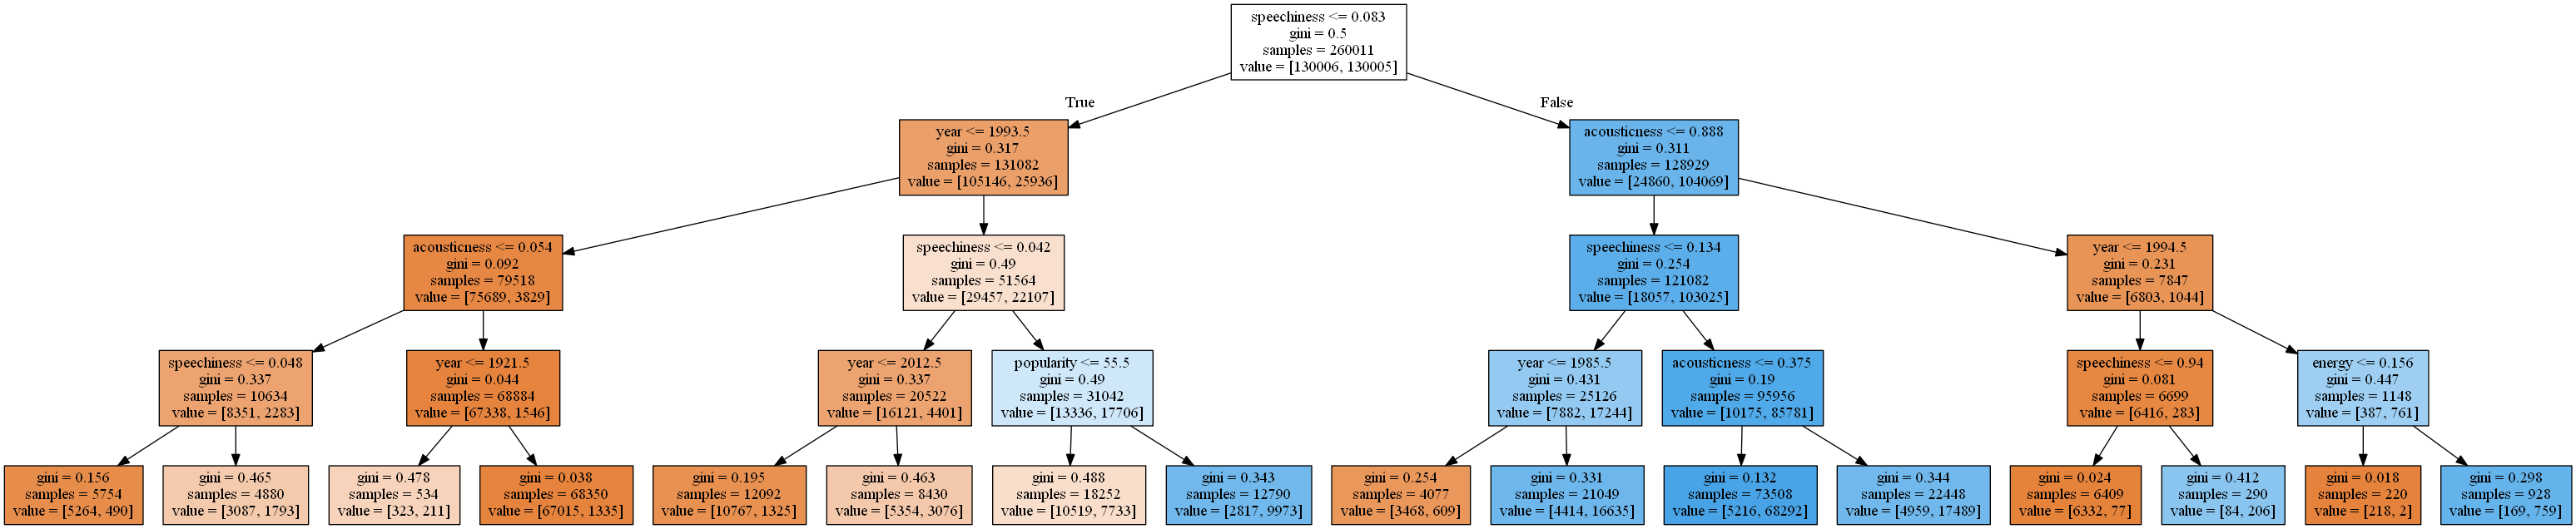

In [99]:
# visualize decision tree
# using third tree because it has the best f-measure, other metrics? 
tree_graph_to_png(tree=scores['estimator'][2], feature_names=sorted(X_res),
                  png_file_to_save='explicit_clf_tree.png')

from IPython.display import Image
from IPython.core.display import HTML 
PATH ='explicit_clf_tree.png'
Image(filename = PATH)

<ipython-input-108-4fa582956924>:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


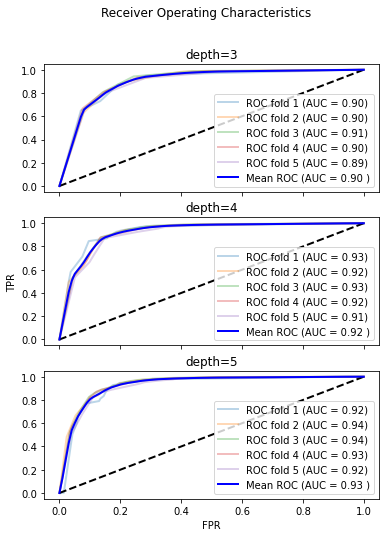

In [108]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# compute ROC curve AUC score
# plot arrows
# excuse the awful spaghetti code 
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(6)
mean_fpr = np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5,shuffle=False)
# tree3
tprs = []
aucs = []
i = 1
for train,test in cv.split(X_res,y_res):
    prediction = clf_tree3.fit(X_res.iloc[train],y_res.iloc[train]).predict_proba(X_res.iloc[test])
    fpr, tpr, t = roc_curve(y_res[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

ax1.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
ax1.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
# tree4
tprs = []
aucs = []
i = 1
for train,test in cv.split(X_res,y_res):
    prediction = clf_tree4.fit(X_res.iloc[train],y_res.iloc[train]).predict_proba(X_res.iloc[test])
    fpr, tpr, t = roc_curve(y_res[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax2.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

ax2.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
ax2.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
# tree5
tprs = []
aucs = []
i = 1
for train,test in cv.split(X_res,y_res):
    prediction = clf_tree5.fit(X_res.iloc[train],y_res.iloc[train]).predict_proba(X_res.iloc[test])
    fpr, tpr, t = roc_curve(y_res[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax3.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

ax3.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
ax3.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

fig.suptitle("Receiver Operating Characteristics")
ax2.set(ylabel='TPR')
ax3.set(xlabel='FPR')
ax1.legend(loc="lower right")
ax1.set_title("depth=3")
ax2.legend(loc="lower right")
ax2.set_title("depth=4")
ax3.legend(loc="lower right")
ax3.set_title("depth=5")
fig.show()